## Advanced Lane Finding Project - Gaspard Shen

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print(fname, ret)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## 2. Distortion Correction to raw images

### Visualize the Camera Calibration 

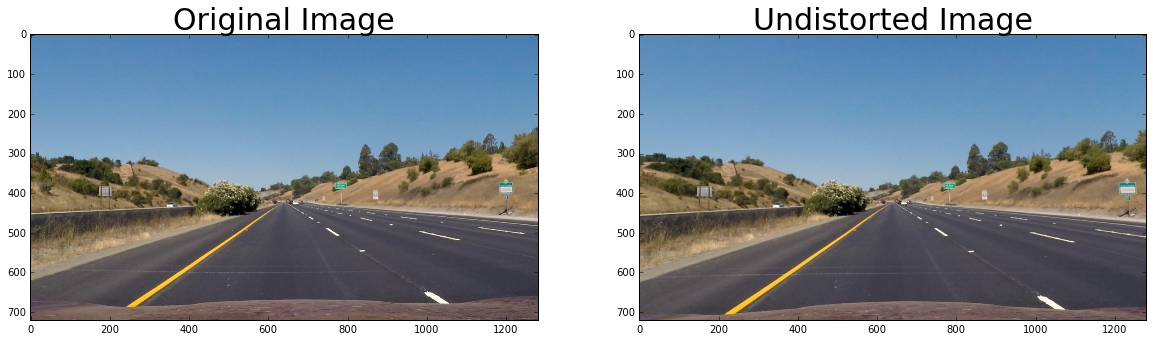

In [2]:
import pickle
%matplotlib inline

# Test undistortion on test image
img = cv2.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/straight_lines1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Apply Camera Calibration to all test images

In [3]:
img = cv2.imread('test_images/straight_lines2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/straight_lines2_undist.jpg',dst)

# Make a list of test images
images = glob.glob('test_images/test*.jpg')
# Apply calibrate to all the test images
for fname in images:
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    filename = fname.split('/')[-1]
    filename = filename.split('.')[0]
    output_path = 'output_images/' + filename + '_undist.jpg'
    cv2.imwrite(output_path ,dst)

print('Done for apply camera calibaration to all test images')    

Done for apply camera calibaration to all test images


## 3. Color transforms, Gradients, to create a thresholded binary image

### Applying Sobel

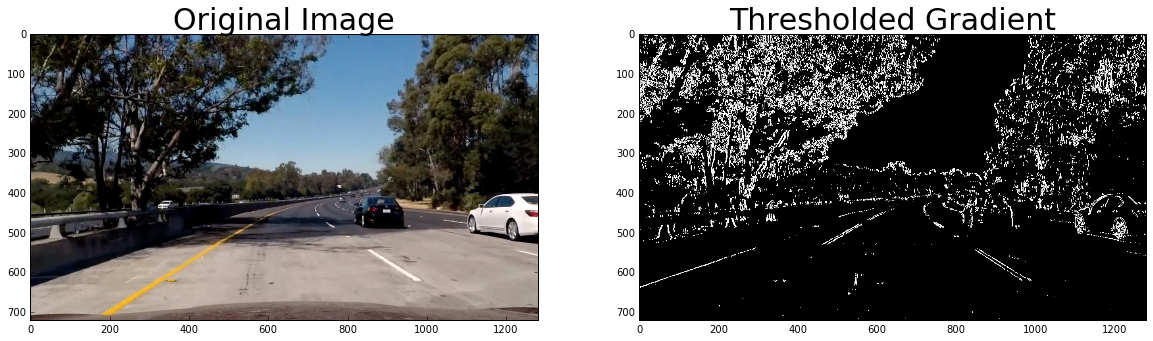

In [4]:
import matplotlib.image as mpimg

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2. Apply x or y gradient wity OpenCV Sobel() and take absolute value
    if orient=='x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient=='y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3. 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4. 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

img = mpimg.imread('output_images/test5_undist.jpg')
grad_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
# Visualize thresholded binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=30)

### Magnitude of the Gradient

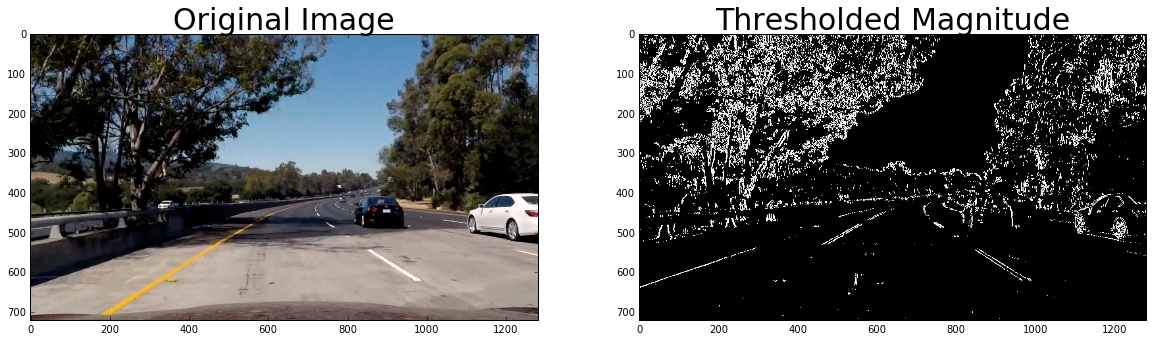

In [5]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

img = mpimg.imread('output_images/test5_undist.jpg')
mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
# Visualize thresholded binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=30)

### Direction of the Gradient

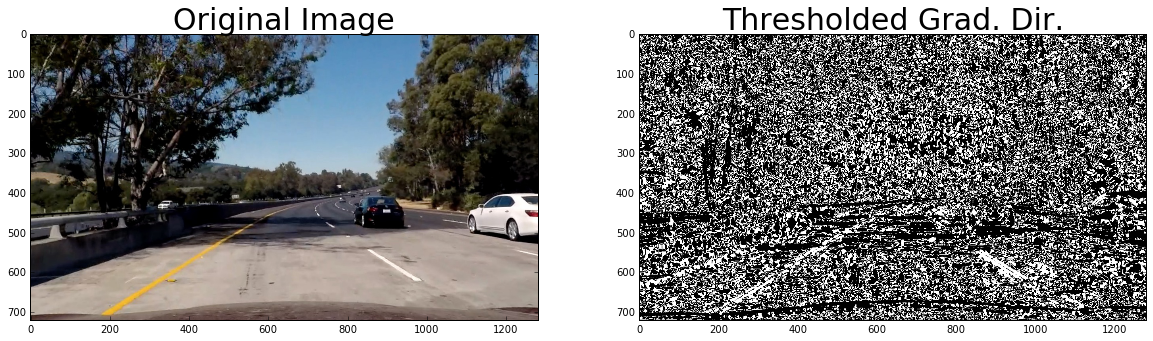

In [6]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Visualize thresholded binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=30)

### HLS

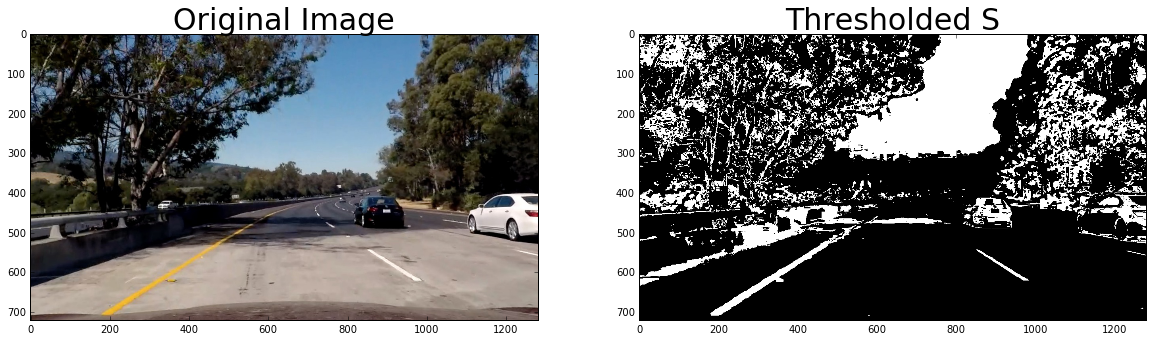

In [8]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(img, thresh=(90, 255))
# Visualize thresholded binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=30)

### Combining Thresholds

In [56]:
def lab_thresh(img, l_yellow, h_yellow, l_white, h_white):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    yellow = cv2.inRange(lab, l_yellow, h_yellow)
    white = cv2.inRange(lab, l_white, h_white)
    mask = cv2.bitwise_or(yellow, white)
    res = cv2.bitwise_and(img, img, mask=mask)
    return mask, res

def color_thresh(img):
    lower_yellow = np.array([0, 0 , 80])
    upper_yellow = np.array([255, 255, 110])
    lower_white = np.array([196, 0, 0])
    upper_white = np.array([255, 255, 255])
    mask, lab = lab_thresh(img, lower_yellow, upper_yellow, lower_white, upper_white)
    return mask, lab

In [57]:
def cvt_binary_img(img):
    # gradient method
    gradx = abs_sobel_thresh(img, 'x', sobel_kernel=3, thresh=(30, 100))
    grady = abs_sobel_thresh(img, 'y', sobel_kernel=3, thresh=(30, 100))
    mag_binary = mag_thresh(img, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    grad = np.zeros_like(gradx)
    grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    color, res = color_thresh(img)

    # Combine two methods
    binary_img = np.zeros_like(gradx)
    binary_img[(grad == 1) | (color == 255)] = 1
    #binary_img[(color == 255)] = 1
    return binary_img

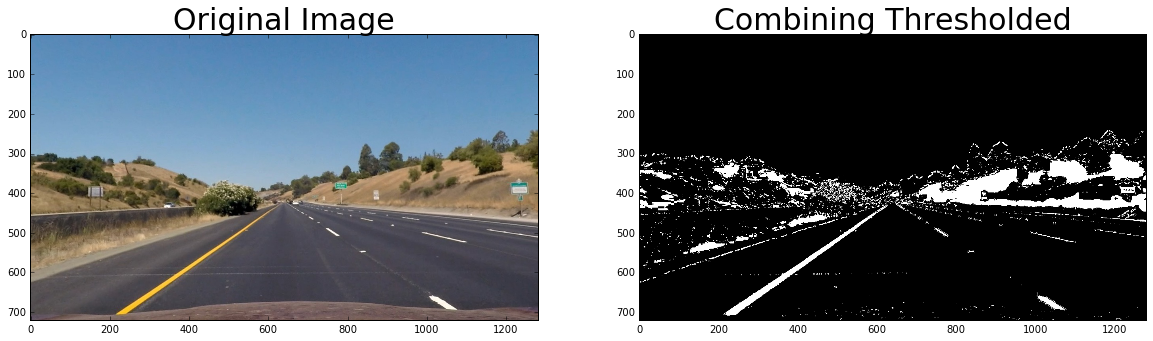

In [60]:
cvt_binary = cvt_binary_img(img)
# Visualize thresholded binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cvt_binary, cmap='gray')
ax2.set_title('Combining Thresholded', fontsize=30)

### Create the thresholded binary images for all test images

In [61]:
# Make a list of test images
images = glob.glob('output_images/*undist.jpg')
for fname in images:
    img = mpimg.imread(fname)
    cvt_binary = cvt_binary_img(img)
    
    filename = fname.split('undist')[0]
    filename = filename + 'thresholded.png'
    mpimg.imsave(filename, cvt_binary, format="png", cmap='gray')

print('Done for thresholded binary image!')

Done for thresholded binary image!


## 4. Perspective Transform

[[  580.   450.]
 [  760.   450.]
 [  160.   688.]
 [ 1140.   688.]]
[[   30.    30.]
 [ 1250.    30.]
 [   30.   690.]
 [ 1250.   690.]]


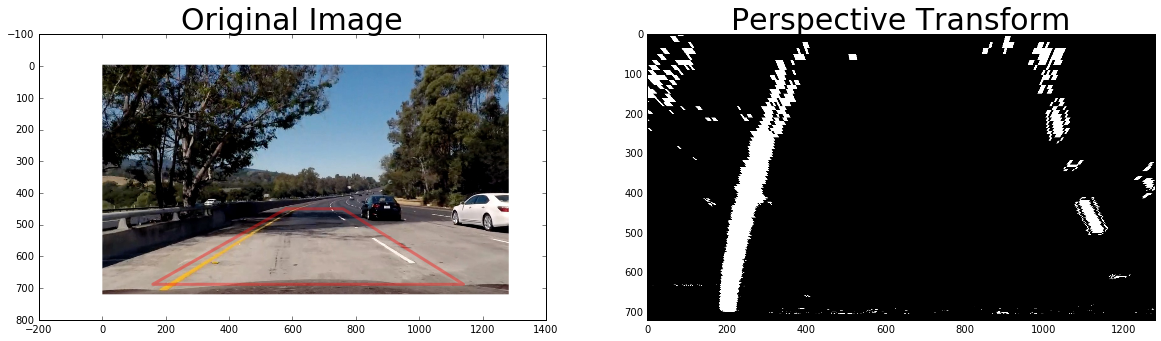

In [63]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

img = mpimg.imread('output_images/test5_undist.jpg')

src = np.float32(
    [[580, 450],
     [760, 450],
     [160, 688],
     [1140,688]])

offset = 30
dst = np.float32(
    [[offset, offset],
     [img.shape[1]-offset, offset],
     [offset, img.shape[0]-offset],
     [img.shape[1]-offset, img.shape[0]-offset]])

print(src)
print(dst)
warped_img = warper(img, src, dst)

binary_warped = warper(cvt_binary, src, dst)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#ff1111', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Perspective Transform', fontsize=30)

### Apply Perspective Transform to all the test images

Done for Perspective Transform!


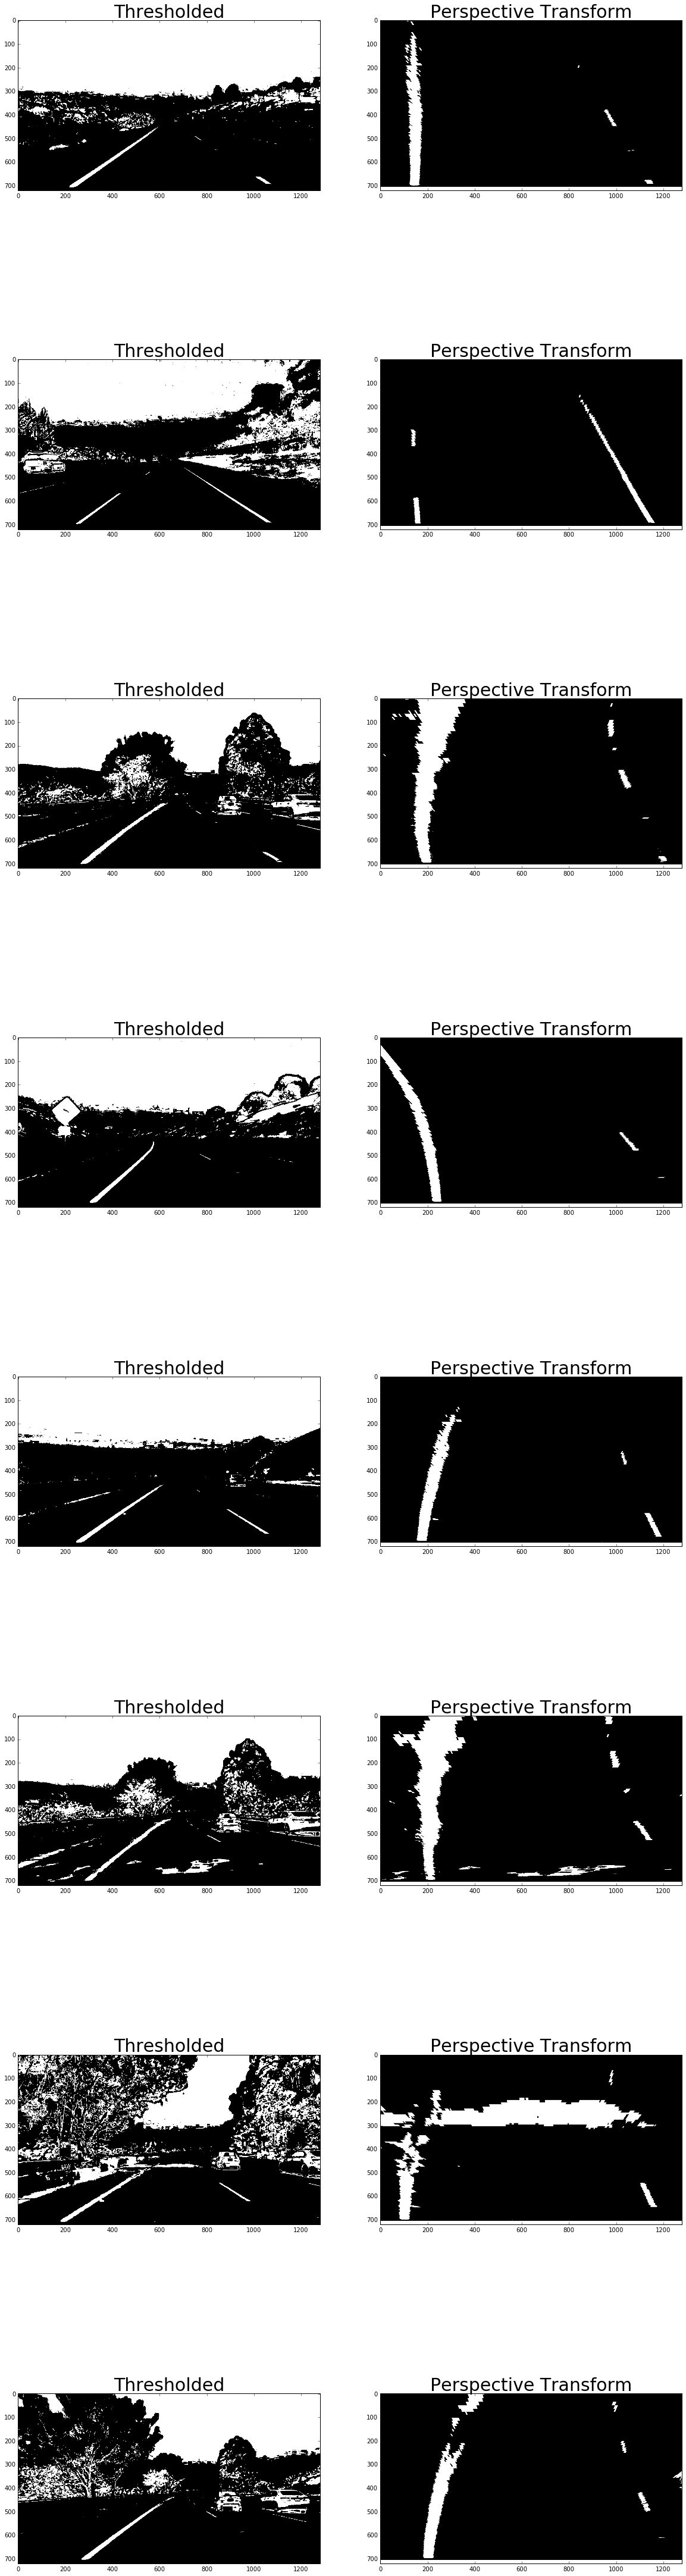

In [11]:
# Make a list of test images
images = glob.glob('output_images/*thresholded.png')
f, ax = plt.subplots(len(images), 2, figsize=(20, 80))

i = 0
for fname in images:
    #print(fname)
    img = mpimg.imread(fname)
    ax[i][0].imshow(img)
    ax[i][0].set_title('Thresholded', fontsize=30)
    
    binary_warped = warper(img, src, dst)
    filename = fname.split('thresholded')[0]
    filename = filename + 'warped.png'
    mpimg.imsave(filename, binary_warped, format="png", cmap='gray')
    ax[i][1].imshow(binary_warped)
    ax[i][1].set_title('Perspective Transform', fontsize=30)
    i = i+1

print('Done for Perspective Transform!')

## 5. Line Finding Method

### Peaks in a Histogram

In [12]:
# Draw a polynomial line on an image
def draw_polyline(img, fit):
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    pts = np.array([np.transpose(np.vstack([x, y]))])
    cv2.polylines(img, np.int_(pts), isClosed=False, color=(255,255,0), thickness=3)
    return img

# Assuming you have created a warped binary image called "binary_warped"
# Set the width of the windows +/- margin
# Set minimum number of pixels found to recenter window
def SearchSlidingWindow(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    draw_polyline(out_img, left_fit)
    draw_polyline(out_img, right_fit)
    
    return left_fit, right_fit, out_img

### Skip the sliding windows step once you know where the lines are

In [13]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def LookAheadFilter(binary_warped, left_fit, right_fit, margin=100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return left_fit, right_fit, result

### Measuring Curvature

In [15]:
# Global variable
ym_per_pix = 20/720
xm_per_pix = 3.7/900

"""
Calculate curvature in meter.
Input: height of an image; a second order polynomial function.
Output: curvature in meter.
"""
def cal_curvature(img_h, fit):
    y = np.linspace(0, img_h-1, img_h)
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    y_eval = y[-1]
    
    # fit x,y in real world
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    curverad = np.round(curverad, 2)
    return curverad

"""
Calculate the curvature in unit of meter.
Input: left lane and right lane polynomial function; an evaluation position
Output: left, right and average curvature.
"""
def LaneCurvature(img_h, left_fit, right_fit):
    avg_fit = np.mean([left_fit, right_fit], axis = 0)
    
    left_curvature = cal_curvature(img_h, left_fit)
    right_curvature = cal_curvature(img_h, right_fit)
    radius_of_curvature = cal_curvature(img_h, avg_fit)
    
    return left_curvature, right_curvature, radius_of_curvature

In [16]:
# Calculate the offset of the car. Assume the camera locates at the middle of the car.
def LaneOffset(height, width, left_fit, right_fit):
    y_eval = height - 1;
    left_x = left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]
    right_x = right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2]
    
    # left x and right x
    car_center = (left_x + right_x)/2
    lane_center = width / 2
    offset = np.abs(car_center - lane_center)
    offset = np.round(offset * xm_per_pix, 3)
    return offset

In [26]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.n = 8 # Number of iterations that's to be averaged
        
        self.width = None
        self.height = None
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        #polynomial coefficients for the most recent fit
        self.curr_left_fit = [] 
        self.curr_right_fit = [] 
                                
        #polynomial coefficients averaged over the last n iterations
        self.best_left_fit = None  
        self.best_right_fit = None 
         
        #radius of curvature of the line in some units
        self.left_curvature = None
        self.right_curvature = None
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
    """
    Sanity check on new found lines.
    Input: left and right lane.
    Output: True or False means pass or not.
    """
    def SanityCheck(self, left_fit, right_fit):
        ploty = np.linspace(0, self.height-1, self.height)
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        # 1. Check if they have similar curvature
        curv_dev = 10 # variance, 5 times
        left_curverad = cal_curvature(self.height, left_fit)
        right_curverad = cal_curvature(self.height, right_fit)
        
        ratio = left_curverad / right_curverad 
        if ((ratio >= curv_dev) | (ratio <= 1./curv_dev)):
            print("ratio", ratio)
            return False
        
        # 2. Check lines are seperated by right distance
        dist_dev = 100
        valid_dist = 850 # Lane line pixel is about 830 wide, stay tuned
        curr_dist = right_fitx[-1] - left_fitx[-1]
        if (np.abs(curr_dist - valid_dist) > dist_dev):
            print("curr dist", curr_dist)
            return False
        
        # 3. Check if lines are roughly paralell
        lines_dev = 80
        dist = right_fitx - left_fitx
        dev = np.std(dist)
        if (dev >= lines_dev):
            print("std dev", dev)
            return False
            
        return True
        
    """
    Find lane pixels given a binary warped image.
    Input: a binary image from birds' eye view.
    Output: left and right lane in polynomial function and a diagnosis image
    """
    def find_lane(self, binary_warped):
        self.width = binary_warped.shape[1]
        self.height = binary_warped.shape[0]
        
        if (self.detected):
            last_left_fit = self.curr_left_fit[-1]
            last_right_fit = self.curr_right_fit[-1]
            left_fit, right_fit, diag_img = LookAheadFilter(binary_warped, last_left_fit, last_right_fit)
        else:
            left_fit, right_fit, diag_img = SearchSlidingWindow(binary_warped)

        self.curr_left_fit.append(left_fit)
        self.curr_right_fit.append(right_fit)
        
        # Only keep last n iterations
        if (len(self.curr_left_fit) > self.n):
            self.curr_left_fit = self.curr_left_fit[-self.n:]
            self.curr_right_fit = self.curr_right_fit[-self.n:]
        
        # average
        self.best_left_fit = np.mean(self.curr_left_fit, axis=0)
        self.best_right_fit = np.mean(self.curr_right_fit, axis=0)
        
        # Calculate curvature and offset
        self.left_curvature, self.right_curvature, self.radius_of_curvature = LaneCurvature(self.height, left_fit, right_fit)
        self.line_base_pos = LaneOffset(self.height, self.width, left_fit, right_fit)
        
        return diag_img
    
    def get_lane(self):
        return self.best_left_fit, self.best_right_fit
    
    def get_curvature(self):
        return self.left_curvature, self.right_curvature, self.radius_of_curvature
    
    def get_offset(self):
        return self.line_base_pos

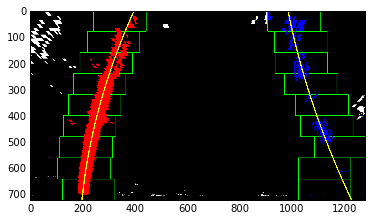

[  2.45463035e-04  -4.53867368e-01   3.97427372e+02] [  1.92012359e-04   1.99378171e-01   9.82399125e+02]
382.44 492.37 429.52
0.294


In [64]:
img = binary_warped
line = Line()

out_img = line.find_lane(img)
left_fit, right_fit = line.get_lane()
left_curv, right_curv, curv = line.get_curvature()
offset = line.get_offset()

plt.imshow(out_img)
plt.show()
print(left_fit, right_fit)
print(left_curv, right_curv, curv)
print(offset)

## 5. Annotate Image

In [36]:
# Draw drivable region, left and right lane on an image.
def draw_region(undist, left_fit, right_fit):
    img_h = undist.shape[0]
    ploty = np.linspace(0, img_h-1, img_h)
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    color_warp = np.zeros_like(undist)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane and drivable region onto the warped blank image
    cv2.polylines(color_warp, np.int_(pts_left), isClosed=False, color=(255,0,0), thickness=80)
    cv2.polylines(color_warp, np.int_(pts_right), isClosed=False, color=(0,0,255), thickness=80)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

In [67]:
"""
Put left, right curvature and average curvature and also the offset on an image
"""
def put_curvature_and_offset(result, left_curverad, right_curverad, curvature, offset):
    left_curv_str = 'Left Curvature: ' + str(left_curverad) + 'm'
    right_curv_str = 'Right Curvature: ' + str(right_curverad) + 'm'
    curv_str = 'Curvature: ' + str(curvature) + 'm'
    offset_str = 'Vehicle center Dist: ' + str(offset) + 'm'
    
    font = cv2.FONT_HERSHEY_COMPLEX
    scale = 1
    white = (255, 255, 255)
    thickness = 2
    cv2.putText(result, left_curv_str, (30, 60), font, scale, white, thickness)
    cv2.putText(result, right_curv_str, (30, 90), font, scale, white, thickness)
    cv2.putText(result, curv_str, (30, 120), font, scale, white, thickness)
    cv2.putText(result, offset_str, (30, 150), font, scale, white, thickness)
    
    return result

In [68]:
"""
Draw dirvable region on an image. Given a Line object.
"""
def annotate_image(undist, line):
    left_fit, right_fit = line.get_lane()
    left_curv, right_curv, curv = line.get_curvature()
    offset = line.get_offset()
    
    result = draw_region(undist, left_fit, right_fit)
    result = put_curvature_and_offset(result, left_curv, right_curv, curv, offset)
    return result

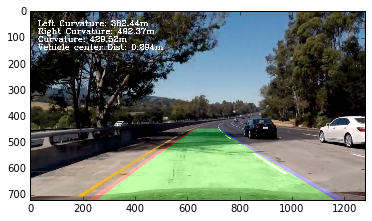

In [69]:
undist = mpimg.imread('output_images/test5_undist.jpg')
result = annotate_image(undist, line)
plt.imshow(result)
plt.show()

## 6. Process Pipeline

In [39]:
line = Line()

def process_image(image, diagnosis=True):
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)
    binary_img = cvt_binary_img(undist_img)
    image_size = (image.shape[1], image.shape[0])
    warp_binary = cv2.warpPerspective(binary_img, M, image_size, cv2.INTER_LINEAR)
    diag_img = line.find_lane(warp_binary)
    result = annotate_image(undist_img, line)

    if diagnosis:
        # Calculate the size of screens
        result_screen_w = result.shape[1]
        result_screen_h = result.shape[0]
        diag_screen_w = np.int(result_screen_w / 3)
        diag_screen_h = np.int(result_screen_h / 3)
        screen_w = result_screen_w + diag_screen_w
        screen_h = result_screen_h
        # Assign result image to the screen
        screen = np.zeros((screen_h, screen_w, 3), dtype=np.uint8)
        screen[0:result_screen_h, 0:result_screen_w] = result
        # Assgin diagnosis image to the screen
        diag_img_1 = np.dstack((binary_img, binary_img, binary_img))*255
        screen[0:diag_screen_h, result_screen_w:, :] = cv2.resize(diag_img_1, (diag_screen_w, diag_screen_h))
        diag_img_2 = np.dstack((warp_binary, warp_binary, warp_binary))*255
        screen[diag_screen_h : diag_screen_h*2, result_screen_w:, :] = cv2.resize(diag_img_2, (diag_screen_w, diag_screen_h))
        screen[diag_screen_h*2 : diag_screen_h*3, result_screen_w:, :] = cv2.resize(diag_img, (diag_screen_w, diag_screen_h))
        return screen
    else: 
        return result
    

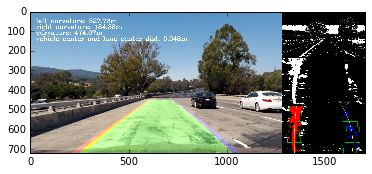

In [49]:
image = mpimg.imread('./test_images/test1.jpg')
out = process_image(image, diagnosis=True)
plt.imshow(out)
plt.show()

## 7. Process Video

In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
line = Line()

white_output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [11:55<00:00,  1.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 11min 27s, sys: 2min 4s, total: 13min 32s
Wall time: 12min


In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [70]:
challenge_output = 'challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [04:34<00:00,  2.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 4min 22s, sys: 48.8 s, total: 5min 11s
Wall time: 4min 37s


In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))